# Object tracking + MOT evaluation (YOLO + Supervision + ByteTrack)

This notebook is organized in **three parts**:

1. **Run detection + tracking on a folder of frames** (JPG images) using **Ultralytics YOLO** and **Supervision ByteTrack**.
2. **Export** the resulting tracked boxes to a simple text format for downstream evaluation.
3. **Plot MOT metrics** (e.g., HOTA / DetA / AssA / LocA) from pre-computed JSON outputs.

> Tip: run the notebook **top-to-bottom**. Most cells are designed to be reusable by only changing the configuration below.


## 0. Setup

Install the dependencies (only if needed) and import libraries.


In [1]:
# Core
import os
import re
import json
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

# Tracking / annotation
import supervision as sv
from ultralytics import YOLO


## 1. Configuration

Edit the paths and parameters here. Everything below will use these values.


In [2]:
# Path to a folder containing frames: 000001.jpg, 000002.jpg, ...
FRAMES_DIR = Path("../data/frames")

# Model checkpoint (Ultralytics)
YOLO_WEIGHTS = "yolov8n.pt"

# Keep only some classes (Ultralytics COCO ids). Example: 0=person, 41=cup, ...
SELECTED_CLASSES = [41]

# ByteTrack parameters (tune for your data)
TRACK_ACTIVATION_THRESHOLD = 0.25
LOST_TRACK_BUFFER = 30
MINIMUM_MATCHING_THRESHOLD = 0.8
FRAME_RATE = 30

# Optional line (for counting crossings). Coordinates must match your frame resolution.
# If you don't need line-crossing, you can ignore this and the line-zone annotator.
LINE_START = sv.Point(50, 1500)
LINE_END   = sv.Point(3840 - 50, 1500)


## 2. Helpers

### 2.1 Load frames (sorted)

We read all `*.jpg` files and sort them by the first number in the filename.


In [3]:
def get_frames_list(frames_dir):
    frames = []
    for f in os.listdir(frames_dir):
        if f.lower().endswith(".jpg"):
            m = re.search(r"\d+", f)
            if m is None:
                continue
            number = int(m.group())
            frames.append((number, frames_dir / f))

    frames.sort(key=lambda x: x[0])
    return [p for _, p in frames]


frames_list = get_frames_list(FRAMES_DIR)
print(f"Found {len(frames_list)} frames in: {FRAMES_DIR.resolve()}")
print("First frame:", frames_list[0] if frames_list else "N/A")


Found 1385 frames in: C:\Users\idris\Desktop\AaCours\Canada\Double_Diplome\Hiver_2024\Computer Vision\TP3_bis\data\frames
First frame: ..\data\frames\frame0.jpg


### 2.2 Quick sanity check

Display one frame to confirm that paths + resolution are correct.


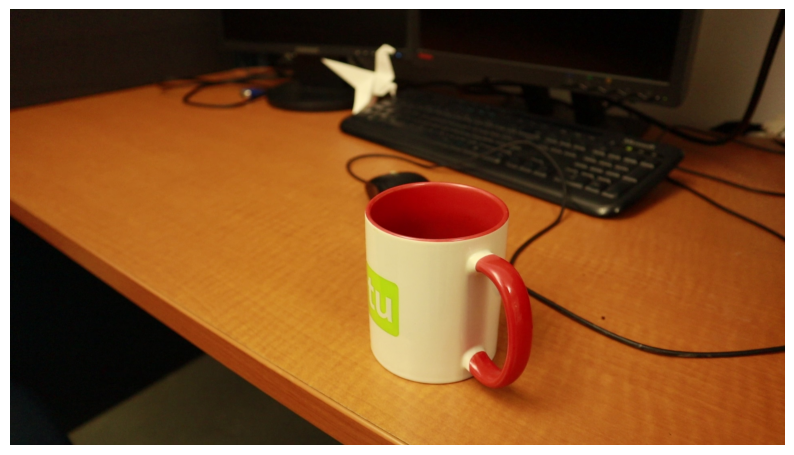

In [4]:
if len(frames_list) > 0:
    sample = cv2.imread(str(frames_list[0]))
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 6))
    plt.imshow(sample)
    plt.axis("off")
    plt.show()


## 3. Model + tracker initialization

- **YOLO** performs object detection.
- **ByteTrack** links detections across frames into track IDs.


In [5]:
model = YOLO(YOLO_WEIGHTS)
CLASS_NAMES = model.model.names  # id -> label

byte_tracker = sv.ByteTrack(
    track_activation_threshold=TRACK_ACTIVATION_THRESHOLD,
    lost_track_buffer=LOST_TRACK_BUFFER,
    minimum_matching_threshold=MINIMUM_MATCHING_THRESHOLD,
    frame_rate=FRAME_RATE,
)

# Optional line-crossing counter
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Annotators (purely visual)
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=1.5)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=1.5)


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


## 4. Run tracking on all frames

Outputs:
- `final_frames`: annotated frames (for visualization)
- `predictions`: list of `[frame_id, track_id, x, y, w, h]` in **pixel** coordinates

Notes:
- The bbox conversion is `xyxy -> xywh` where `x,y` is top-left corner.
- Filtering by `SELECTED_CLASSES` happens before tracking.


In [6]:
from tqdm.auto import tqdm
import time

byte_tracker.reset()

final_frames = []
predictions = []

t0 = time.time()
pbar = tqdm(list(enumerate(frames_list)), total=len(frames_list), desc="Processing frames")

for frame_id, frame_path in pbar:
    frame_bgr = cv2.imread(str(frame_path))
    if frame_bgr is None:
        raise ValueError(f"Could not read frame: {frame_path}")

    results = model(frame_bgr, verbose=False)[0]

    det = sv.Detections.from_ultralytics(results)
    if SELECTED_CLASSES is not None and len(SELECTED_CLASSES) > 0 and det.class_id is not None:
        det = det[np.isin(det.class_id, SELECTED_CLASSES)]

    det = byte_tracker.update_with_detections(det)

    # Save predictions
    if len(det) > 0:
        for i in range(len(det)):
            x1, y1, x2, y2 = det.xyxy[i]
            track_id = int(det.tracker_id[i]) if det.tracker_id is not None else -1
            w, h = float(x2 - x1), float(y2 - y1)
            predictions.append([frame_id, track_id, float(x1), float(y1), w, h])

    line_zone.trigger(det)

    labels = []
    if len(det) > 0:
        for i in range(len(det)):
            tid = int(det.tracker_id[i]) if det.tracker_id is not None else -1
            cid = int(det.class_id[i]) if det.class_id is not None else -1
            c = float(det.confidence[i]) if det.confidence is not None else 0.0
            cname = CLASS_NAMES[cid] if (0 <= cid < len(CLASS_NAMES)) else "cls?"
            labels.append(f"#{tid} {cname} {c:0.2f}")

    annotated = trace_annotator.annotate(scene=frame_bgr.copy(), detections=det)
    annotated = box_annotator.annotate(scene=annotated, detections=det, labels=labels)
    annotated = line_zone_annotator.annotate(annotated, line_counter=line_zone)
    final_frames.append(annotated)

    # Progress info
    elapsed = time.time() - t0
    fps = (frame_id + 1) / elapsed if elapsed > 0 else 0.0
    pbar.set_postfix(fps=f"{fps:.2f}", dets=len(det), tracks=(len(set(det.tracker_id)) if det.tracker_id is not None else 0))


Processing frames:   0%|          | 0/1385 [00:00<?, ?it/s]

### 4.1 Visualize a few annotated frames

Pick a few indices to inspect tracking quality.


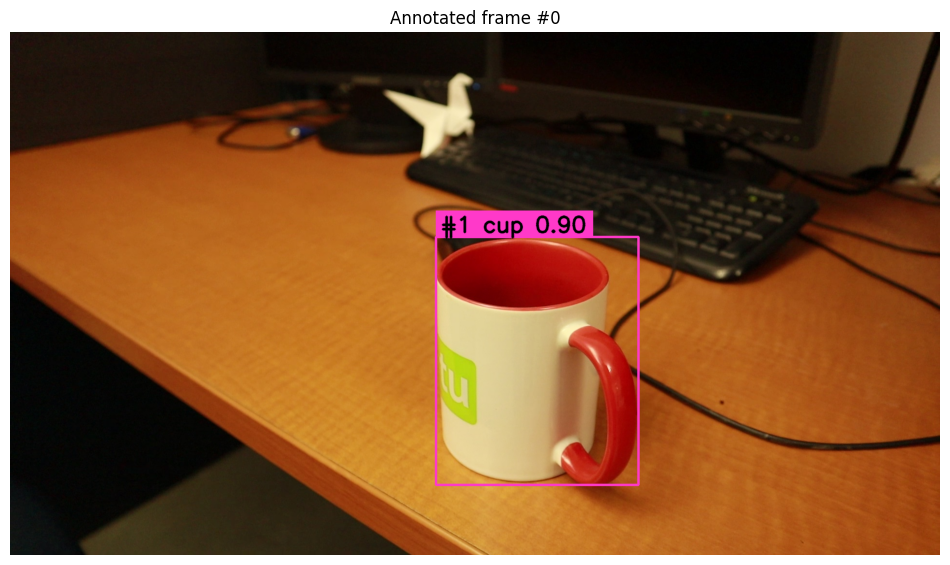

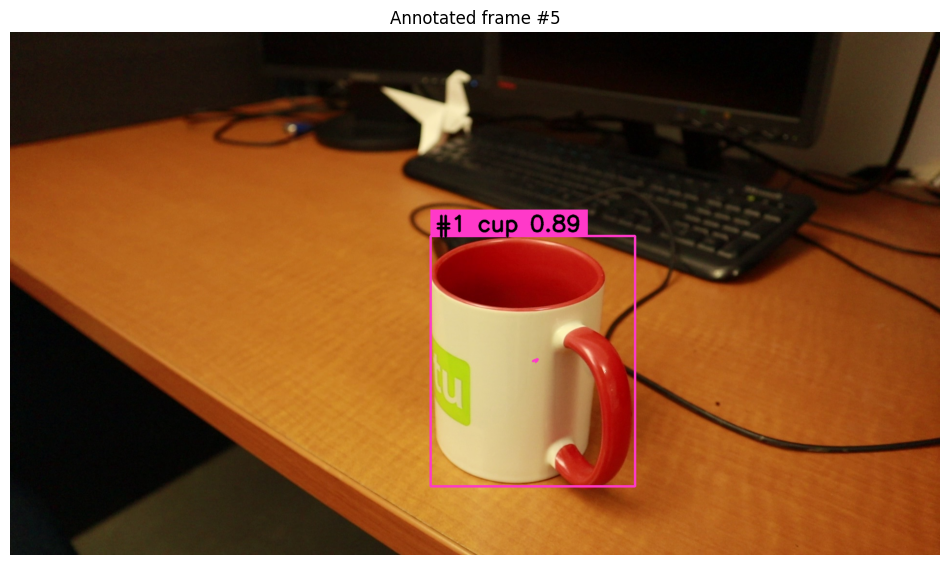

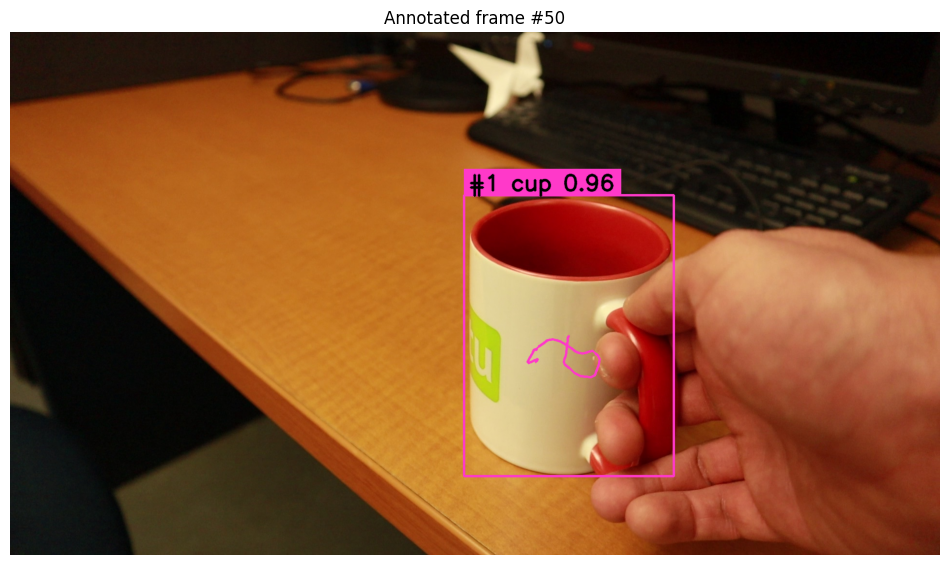

In [7]:
def show_frame(idx: int):
    idx = int(np.clip(idx, 0, len(final_frames) - 1))
    rgb = cv2.cvtColor(final_frames[idx], cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 7))
    plt.imshow(rgb)
    plt.title(f"Annotated frame #{idx}")
    plt.axis("off")
    plt.show()

if len(final_frames) > 0:
    for idx in [0, min(5, len(final_frames)-1), min(50, len(final_frames)-1)]:
        show_frame(idx)


## 5. Export predictions

This exports one line per detection:

`frame_id track_id x y w h`

If your evaluator expects a different format (e.g., MOTChallenge), adapt this cell.


In [8]:
OUTPUT_TXT = Path("output.txt")

with open(OUTPUT_TXT, "w", encoding="utf-8") as f:
    for row in predictions:
        f.write(" ".join(map(lambda v: f"{v}", row[:6])) + "\n")

print("Wrote:", OUTPUT_TXT.resolve())


Wrote: C:\Users\idris\Desktop\AaCours\Canada\Double_Diplome\Hiver_2024\Computer Vision\TP3_bis\ByteTrack\output.txt


## 6. Optional: write an annotated video

If you want to see the tracking as a video, this cell writes an `.mp4`.


In [9]:
# Comment this out if you don't want video output
WRITE_VIDEO = False
VIDEO_PATH = Path("annotated.mp4")

if WRITE_VIDEO and len(final_frames) > 0:
    h, w = final_frames[0].shape[:2]
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(str(VIDEO_PATH), fourcc, FRAME_RATE, (w, h))

    for fr in final_frames:
        out.write(fr)

    out.release()
    print("Video written to:", VIDEO_PATH.resolve())


# Part B — Plot MOT metrics from JSON

This section assumes you already have evaluation JSON files on disk.
The notebook originally used:

- `../output_data.json`
- `../output_data_final.json`

Adjust paths below to match your setup.

The plotting utilities focus on the **pedestrian** class and the **HOTA family** metrics:
- **HOTA** (overall)
- **DetA** (detection accuracy)
- **AssA** (association accuracy)
- **LocA** (localization accuracy)


In [10]:
OUTPUT_DATA_JSON = Path("../output_data.json")
OUTPUT_DATA_FINAL_JSON = Path("../output_data_final.json")

data = None
dataf = None

if OUTPUT_DATA_JSON.exists():
    with open(OUTPUT_DATA_JSON, "r", encoding="utf-8") as f:
        data = json.load(f)

if OUTPUT_DATA_FINAL_JSON.exists():
    with open(OUTPUT_DATA_FINAL_JSON, "r", encoding="utf-8") as f:
        dataf = json.load(f)

print("Loaded data:", OUTPUT_DATA_JSON.exists(), "| Loaded dataf:", OUTPUT_DATA_FINAL_JSON.exists())


Loaded data: True | Loaded dataf: True


## 7. Plotting utilities

These helper functions assume a structure like:

`data[model][benchmark][run_name][sequence]["pedestrian"]["HOTA"][metric]`

If your JSON schema differs, edit the access paths inside the functions.


In [11]:
def plot_result(data_seq: dict, dataset_name: str, model_name: str):
    """Line plots across alpha thresholds for HOTA, DetA, AssA, LocA."""
    x = np.linspace(0, 1, num=len(data_seq["pedestrian"]["HOTA"]["HOTA"]))

    hota = np.array(data_seq["pedestrian"]["HOTA"]["HOTA"])
    deta = np.array(data_seq["pedestrian"]["HOTA"]["DetA"])
    assa = np.array(data_seq["pedestrian"]["HOTA"]["AssA"])
    loca = np.array(data_seq["pedestrian"]["HOTA"]["LocA"])

    plt.figure(figsize=(10, 5))
    plt.plot(x, hota, label="HOTA")
    plt.plot(x, deta, label="DetA")
    plt.plot(x, assa, label="AssA")
    plt.plot(x, loca, label="LocA")
    plt.title(f"{dataset_name} — {model_name}")
    plt.xlabel("alpha threshold")
    plt.ylabel("score")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def plot_scores_table(data_seq: dict, alphas=(0.25, 0.5, 0.75), metrics=("HOTA", "DetA", "AssA", "LocA")):
    """Print a small table of selected metrics at selected alpha thresholds."""
    alpha_vals = np.linspace(0, 1, num=len(data_seq["alpha_vals"])) if "alpha_vals" in data_seq else np.linspace(0, 1, num=len(data_seq["pedestrian"]["HOTA"]["HOTA"]))
    rows = []
    for a in alphas:
        idx = int(np.argmin(np.abs(alpha_vals - a)))
        row = {"alpha": float(alpha_vals[idx])}
        for m in metrics:
            row[m] = float(data_seq["pedestrian"]["HOTA"][m][idx])
        rows.append(row)

    # Pretty print
    header = ["alpha"] + list(metrics)
    print(" | ".join(f"{h:>6}" for h in header))
    print("-" * (9 * len(header)))
    for r in rows:
        print(" | ".join([f"{r['alpha']:6.2f}"] + [f"{r[m]:6.3f}" for m in metrics]))


def plot_average_scores_bar(data_seq: dict, dataset_name: str, model_name: str):
    """Bar chart of average HOTA/DetA/AssA/LocA over alpha thresholds."""
    hota_avg = float(np.mean(data_seq["pedestrian"]["HOTA"]["HOTA"]))
    deta_avg = float(np.mean(data_seq["pedestrian"]["HOTA"]["DetA"]))
    assa_avg = float(np.mean(data_seq["pedestrian"]["HOTA"]["AssA"]))
    loca_avg = float(np.mean(data_seq["pedestrian"]["HOTA"]["LocA"]))

    metrics = ["HOTA", "DetA", "AssA", "LocA"]
    values = [hota_avg, deta_avg, assa_avg, loca_avg]

    plt.figure(figsize=(7, 4))
    plt.bar(metrics, values)
    plt.ylim(0, 1)
    plt.title(f"Average scores — {dataset_name} / {model_name}")
    plt.ylabel("score")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()


## 8. Example: plot one sequence

Update the dictionary keys below to match your JSON.
If the file doesn't exist, this cell will do nothing.


Detected example path: ByteTrack_yolov9c.pt -> MotChallenge2DBox -> MPNTrack_ByteTrack_yolov9c.pt -> MOT17-02-DPM -> pedestrian -> HOTA -> HOTA


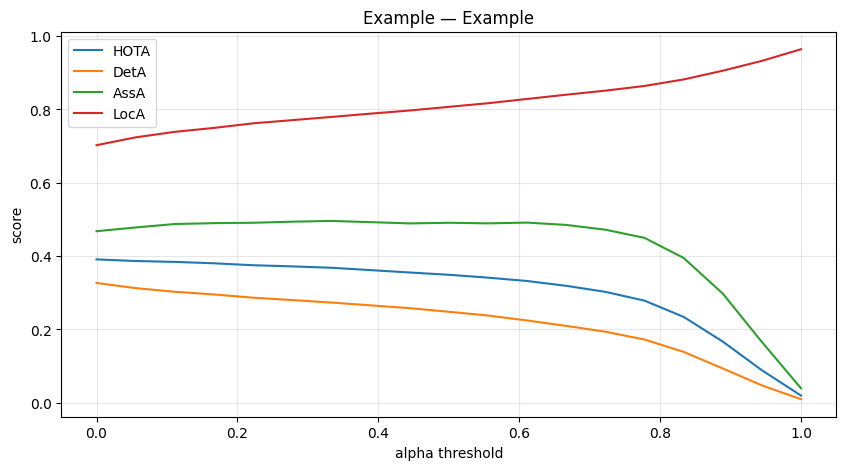

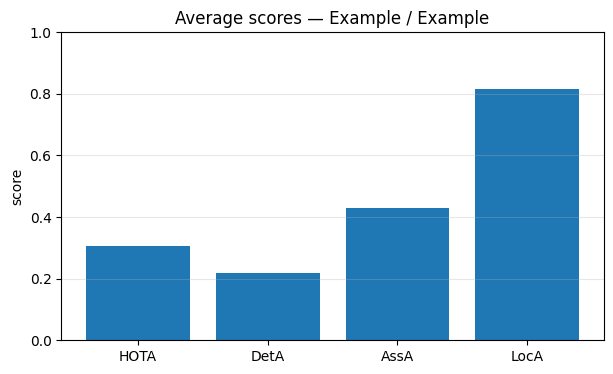

 alpha |   HOTA |   DetA |   AssA |   LocA
---------------------------------------------
  0.22 |  0.375 |  0.287 |  0.491 |  0.762
  0.50 |  0.349 |  0.248 |  0.491 |  0.807
  0.78 |  0.279 |  0.173 |  0.450 |  0.864


In [12]:
if data is not None:

    def first_leaf(d):
        cur = d
        path = []
        while isinstance(cur, dict):
            k = next(iter(cur.keys()))
            path.append(k)
            cur = cur[k]
        return path

    path = first_leaf(data)
    print("Detected example path:", " -> ".join(path))

    cur = data
    for k in path:
        cur = cur[k]
        if isinstance(cur, dict) and "pedestrian" in cur and "HOTA" in cur["pedestrian"]:
            break

    if isinstance(cur, dict) and "pedestrian" in cur:
        plot_result(cur, dataset_name="Example", model_name="Example")
        plot_average_scores_bar(cur, dataset_name="Example", model_name="Example")
        plot_scores_table(cur)
    else:
        print("Could not find a leaf with pedestrian/HOTA in the automatically selected path. Edit the access keys manually.")
else:
    print("No data loaded (missing JSON).")


## Pedestrian crops (output_DPM)

This section extracts pedestrian crops from the original frames using the tracking results
stored in `predictions` (no need to rerun YOLO or ByteTrack).
Images are saved in `output_DPM/` and named by frame id and track id.


YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs
Nb frames: 654


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


Tracking MOT17-10-DPM:   0%|          | 0/654 [00:00<?, ?it/s]

predictions :
 [[1, 1, 469.19824, 423.23386, 70.83295, 184.29984], [1, 2, 1470.0535, 417.5357, 80.09509, 176.48566], [1, 3, 1368.5814, 395.09076, 62.737427, 221.4737], [1, 4, 635.1786, 425.79437, 45.270325, 153.34137], [1, 5, 685.8288, 413.72192, 59.223816, 190.0144], [1, 6, 0.5159607, 347.369, 360.25244, 406.02982], [1, 7, 738.7096, 426.3758, 47.488403, 172.2038], [1, 8, 1175.1824, 411.9959, 34.44873, 104.73633], [1, 9, 553.42456, 432.05573, 46.535156, 168.65399], [1, 10, 1194.3538, 409.33057, 32.153076, 104.20593], [1, 11, 598.5066, 428.46277, 43.38867, 167.01965], [1, 12, 567.1709, 432.97998, 53.667786, 167.37646], [1, 13, 1183.4395, 411.66962, 40.665894, 104.15704], [1, 14, 1108.1909, 412.79297, 29.96814, 81.4032], [2, 1, 464.20453, 419.4609, 71.35791, 185.76218], [2, 2, 1463.6763, 420.29858, 78.686646, 173.27667], [2, 3, 1365.4316, 398.42175, 61.986084, 218.70221], [2, 4, 630.33887, 421.5401, 47.000427, 159.33112], [2, 5, 679.735, 409.6391, 59.44873, 190.75311], [2, 6, -11.095873,

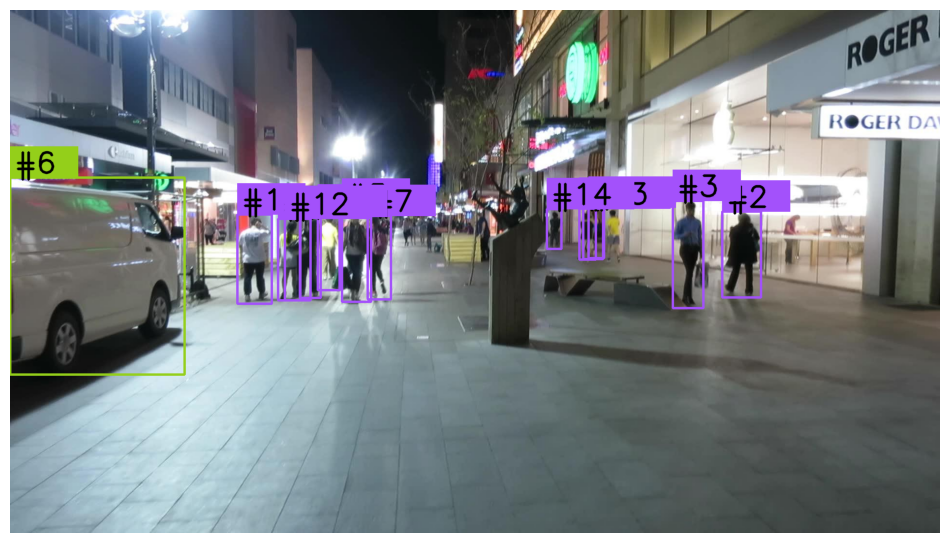

Le contenu a été écrit dans le fichier 'output_DPM_10.txt'.


In [13]:
import supervision as sv
import os
import re
import time

from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


# =========================
# MODEL
# =========================
model = YOLO("yolov8n.pt")
model.info()

# =========================
# DATA (DPM)
# =========================
images_folder = "../MOT17/train/MOT17-10-DPM/img1"

def get_frames_list(images_folder):
    frames_list = []
    for frame in os.listdir(images_folder):
        if frame.endswith(".jpg"):
            number = int(re.search(r"\d+", frame).group())
            frames_list.append((number, os.path.join(images_folder, frame)))
    frames_list = sorted(frames_list, key=lambda x: x[0])
    return [frame[1] for frame in frames_list]

frames_list_DPM10 = get_frames_list(images_folder)
print("Nb frames:", len(frames_list_DPM10))


# =========================
# CONSTANTS
# =========================
CLASS_NAMES_DICT = model.model.names

LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840 - 50, 1500)

selected_classes = [0]  # unused in your code (kept)


# =========================
# TRACKING + ANNOTATORS
# =========================
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30
)
byte_tracker.reset()

line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)


# =========================
# MAIN LOOP (WITH TQDM)
# =========================
final_frames_DPM10 = []
predictions_DPM10 = []

t0 = time.time()
pbar = tqdm(enumerate(frames_list_DPM10), total=len(frames_list_DPM10), desc="Tracking MOT17-10-DPM")

for frame_id, frame_path in pbar:
    frame = cv2.imread(frame_path)
    if frame is None:
        raise ValueError(f"Could not read frame: {frame_path}")

    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    # Uncomment if you really want to filter by class:
    # detections = detections[np.isin(detections.class_id, selected_classes)]

    detections = byte_tracker.update_with_detections(detections)

    labels = [f"#{tracker_id} " for tracker_id in detections.tracker_id]

    annotated_frame = box_annotator.annotate(
        scene=frame.copy(),
        detections=detections,
        labels=labels
    )

    for detection in detections:
        xyxy = detection[0]
        ret = np.asarray(xyxy).copy()
        ret[2:] -= ret[:2]  # xyxy -> xywh

        xmin, ymin, width, height = ret
        xywh = [frame_id + 1, detection[4], xmin, ymin, width, height]
        predictions_DPM10.append(xywh)

    line_zone.trigger(detections)
    line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

    final_frames_DPM10.append(annotated_frame)

    elapsed = time.time() - t0
    fps = (frame_id + 1) / elapsed if elapsed > 0 else 0.0
    pbar.set_postfix(fps=f"{fps:.2f}", dets=len(detections), preds=len(predictions_DPM10))


# =========================
# CHECK OUTPUTS
# =========================
print("predictions :\n", predictions_DPM10[:20], "\n")

plt.figure(figsize=(12, 7))
plt.imshow(cv2.cvtColor(final_frames_DPM10[0], cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


# =========================
# WRITE TXT (MOT FORMAT-LIKE)
# =========================
with open("output_DPM_10.txt", "w") as fichier:
    for sous_liste in predictions_DPM10:
        fichier.write(",".join(map(str, sous_liste[:6])) + ",-1,-1,-1,-1\n")

print("Le contenu a été écrit dans le fichier 'output_DPM_10.txt'.")
